# Collaborative filtering with Cross Entropy
From the "Further reseach" assignments in Chapter 8:
> Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

## Get the data
Follow all the steps of the Chapter

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [8]:
ratings['rating'].unique()

array([3, 5, 4, 2, 1])

In [9]:
ratings['rating'].fillna(0).unique()

array([3, 5, 4, 2, 1])

In [10]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

## Build the model
In order to use Cross Entropy as loss function, we need to think the scores as classes (1, 2, 3, 4, 5) and to build a model which outputs 5 different activations, on which the Cross Entropy loss is computed.

It is not clear if this can be done in the *PMF* approach yet, but for sure it can be done in the NN approach, in which ww just need to change the size of the output layer.

In [39]:
class CollabNNCE(Module):
  def __init__(self, user_sz, movie_sz):
    self.users_factors = Embedding(*user_sz)
    self.movies_factors = Embedding(*movie_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+movie_sz[1], 100),
        nn.ReLU(),
        nn.Linear(100,20),
        nn.ReLU(),
        nn.Linear(20,5)
    )

  def forward(self,x):
    users = self.users_factors(x[:,0])
    movies = self.movies_factors(x[:,1])
    facts = torch.cat( (users, movies), dim=1 )
    return self.layers( facts )


In [12]:
x,y = to_cpu(dls.one_batch())

In [13]:
x.ndim

2

In [14]:
x.shape,y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [15]:
x[0],y[0]

(tensor([661, 659]), tensor([4], dtype=torch.int8))

Weird: I expected one of them to be a string, i.e. the title of the movie ...

In [16]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [17]:
embs[0][1] + embs[1][1]

176

In [40]:
model = CollabNNCE(*embs)

In [41]:
model.users_factors

Embedding(944, 74)

In [20]:
x

tensor([[ 661,  659],
        [ 861,  730],
        [ 766,    8],
        [  13, 1153],
        [ 429, 1185],
        [ 488, 1242],
        [ 675, 1638],
        [ 271,  987],
        [ 677,  772],
        [ 301, 1139],
        [ 874,  830],
        [ 593, 1097],
        [ 814, 1065],
        [ 897,  274],
        [ 635, 1370],
        [ 567, 1067],
        [ 399,  241],
        [ 649, 1524],
        [ 309, 1347],
        [ 378,  356],
        [ 104, 1589],
        [ 197,  622],
        [ 886, 1442],
        [  78, 1610],
        [ 480,  774],
        [ 457,  110],
        [ 815, 1290],
        [ 840,  624],
        [ 804,  180],
        [ 627, 1017],
        [ 102,  600],
        [ 904,  374],
        [ 301,  262],
        [ 561,  374],
        [ 301,  754],
        [ 439,  426],
        [ 171, 1303],
        [ 730, 1102],
        [ 239, 1649],
        [ 454,  274],
        [ 871, 1616],
        [ 653, 1246],
        [ 116,  927],
        [ 189, 1270],
        [ 524, 1457],
        [ 

In [21]:
model(x)

tensor([[-0.0437,  0.2194, -0.0237,  0.1367, -0.1264],
        [-0.0439,  0.2196, -0.0188,  0.1354, -0.1193],
        [-0.0439,  0.2191, -0.0201,  0.1345, -0.1252],
        [-0.0431,  0.2179, -0.0241,  0.1366, -0.1255],
        [-0.0422,  0.2230, -0.0174,  0.1376, -0.1204],
        [-0.0405,  0.2257, -0.0222,  0.1413, -0.1277],
        [-0.0406,  0.2213, -0.0212,  0.1363, -0.1238],
        [-0.0452,  0.2200, -0.0241,  0.1352, -0.1248],
        [-0.0422,  0.2199, -0.0203,  0.1371, -0.1233],
        [-0.0464,  0.2195, -0.0127,  0.1313, -0.1160],
        [-0.0449,  0.2208, -0.0216,  0.1380, -0.1249],
        [-0.0494,  0.2248, -0.0209,  0.1351, -0.1252],
        [-0.0438,  0.2193, -0.0245,  0.1404, -0.1275],
        [-0.0470,  0.2180, -0.0184,  0.1329, -0.1222],
        [-0.0431,  0.2198, -0.0190,  0.1326, -0.1196],
        [-0.0426,  0.2243, -0.0169,  0.1378, -0.1211],
        [-0.0431,  0.2196, -0.0210,  0.1354, -0.1248],
        [-0.0429,  0.2180, -0.0131,  0.1326, -0.1138],
        [-

In [22]:
preds = model(x)
preds.shape, y.shape

(torch.Size([64, 5]), torch.Size([64, 1]))

In [23]:
preds[0,:],preds[0,0],y[0]

(tensor([-0.0437,  0.2194, -0.0237,  0.1367, -0.1264], grad_fn=<SliceBackward>),
 tensor(-0.0437, grad_fn=<SelectBackward>),
 tensor([4], dtype=torch.int8))

In [24]:
preds[0,0].dtype

torch.float32

In [25]:
y[0]

tensor([4], dtype=torch.int8)

In [26]:
torch.unique(y.long())

tensor([1, 2, 3, 4, 5])

In [27]:
preds[5],y.squeeze().long()[5]

(tensor([-0.0405,  0.2257, -0.0222,  0.1413, -0.1277], grad_fn=<SelectBackward>),
 tensor(3))

In this problem there are 5 classes spanning from 1 to 5, while usually they would span from 0 to 4, as a model with 5 activations would expect. Because of this the loss function has to be customized:


In [28]:
loss = CrossEntropyLossFlat()

def myLoss(prediction, target):
  return loss(prediction, target-1)  

In [29]:
myLoss(preds,y)

TensorBase(1.6253, grad_fn=<AliasBackward>)

In [30]:
def myAccuracy(prediction, target):
  return accuracy(prediction, target-1)

In [31]:
accuracy(preds,y),myAccuracy(preds,y)

(TensorBase(0.0781), TensorBase(0.0938))

Now plug the Cross Entropy loss in the learner! Since now it's a classification problem, I use accuracy as metric)

In [42]:
learn = Learner(dls, model, loss_func=myLoss, metrics=myAccuracy)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.019054606556892395)

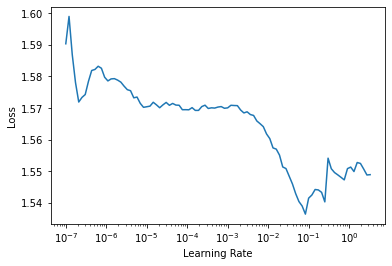

In [43]:
learn.lr_find()

In [44]:
learn.fit_one_cycle(5, 1e-2, wd=.01)

epoch,train_loss,valid_loss,myAccuracy,time
0,1.296440,1.299143,0.421000,00:10
1,1.248543,1.277062,0.429300,00:10
2,1.226791,1.252851,0.443300,00:10
3,1.179362,1.239034,0.449850,00:10
4,1.135234,1.248899,0.449200,00:09
